In [37]:
# Third-party imports
from math import ceil
import numpy as np
import os
import vrplib

# Own imports
from src.new.acs import BWAS
from src.new.ants import FreeAnt
from src.new.display import DisplayModel
from src.new.helpers import create_directory, download_instance, get_distances_matrix
from src.new.heuristics import HeuristicModel
from src.new.machine_learning import KMeans
from src.new.metaheuristics import GeneralVNS
from src.new.models import VRPModel


In [38]:
# Parameters to handle the algorithm
%matplotlib inline

ALPHA = 1 # 0.75, 1, 1.05, 1.1, 1.25, 1.5, 1.75, 2
ANTS_NUM_RELATION = 2  # 1, 2
BETA = 2  # 2, 2.5, 3,  3.5
CANDIDATE_NODES_TYPE = 'best'  # None, 'best', 'random'
GAMMA = 0  # 1, 1.5 2
HEURISTICS_TO_USE = ['distance', 'saving', 'capacity'] # ['distance'], ['distance', 'saving'], ['distance', 'capacity'],  ['distance', 'saving', 'capacity']
INITIAL_PHEROMONES_TYPE = 'tau_zero' # 'tau_max', 'tau_zero'
ITERATION_LOCAL_SEARCH_MODEL = None  # None, GeneralVNS
LAMBDA = 0
MAX_ITERATIONS = 500
MIN_ITERATIONS = 500
MUTATION_TYPE = None # None, 'rows', 'arcs'
P_M = 0.2 # 0.05, 0.1, 0.15, 0.2, 0.25, 0.3
PHEROMONES_ONLINE_UPDATE = False  # True, False
PHEROMONES_UPDATE_TYPE = 'pseudo_g_best' # None, 'all_ants', 'it_best', 'g_best', 'pseudo_g_best'
PROBABILITIES_MATRIX_TYPE = 'normalized'  # 'classic', 'normalized'
Q_0 = 0.7 # None, 0.8, 0.85, 0.9, 0.95
RHO = 0.2  # 0.05, 0.1, 0.15, 0.2, 0.25, 0.3
SIGMA = 2  # 1, 2, 3, 4
SIMILARITY_OF_ARCS_STAGNATION = 0.7 # None, 0.5, 0.6, 0.7, 0.75, 0.8
SIMILARITY_OF_QUALITIES_STAGNATION = None # None, 0.885, 0.89, 0.9, 0.92, 0.95, 0.99
TARE_PERCENTAGE = 0.15

# Instance to solve
LIB = 'CMT'
INSTANCE = 'CMT2'

# Parameters to handle the display
PLOT_INSTANCE = False
PLOT_CLUSTERS = False
PLOT_SOLUTION = True
PLOT_MOST_USED_ARCS = False
PLOT_PHEROMONES_MATRIX = True


In [39]:
# Initialize everything
project_path = os.getcwd()
instance_file_exists = os.path.isfile(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')

if not instance_file_exists:
    create_directory(f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}/')
    success = download_instance(
        INSTANCE, f'{project_path}/instances/CVRPLIB/{LIB}/')

    if not success:
        raise Exception('Error downloading the instance')


instance = vrplib.read_instance(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')
solution = vrplib.read_solution(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.sol')

demands = instance['demand']
nodes = [node for node in range(len(demands))]
clients = nodes[1:]
max_capacity = instance['capacity']
matrix_coords = instance['node_coord']
k_optimal = ceil(sum(demands)/max_capacity)

optimal_cost = None
if solution['cost']:
    optimal_cost = solution['cost']
else:
    optimal_cost = float(instance['comment']) if instance['comment'] else None

errors = VRPModel.validate_instance(nodes, demands, max_capacity)
if errors:
    raise Exception(errors)

iterations = max(round(len(nodes), -2), MIN_ITERATIONS)
matrix_distances = get_distances_matrix(nodes, matrix_coords)

parameters_heuristics = {
    'demands': demands,
    'importance_capacity': LAMBDA,
    'importance_distances': BETA,
    'importance_savings': GAMMA,
    'matrix_coords': matrix_coords,
    'max_capacity': max_capacity,
    'nodes': nodes[:],
}

heuristics = HeuristicModel(**parameters_heuristics)
matrix_heuristics = heuristics.get_heuristic_matrix(HEURISTICS_TO_USE)

parameters_kmeans = {
    'demands': np.array(demands),
    'k_optimal': k_optimal,
    'matrix_coords': matrix_coords[:],
    'matrix_distances': matrix_distances[:],
    'max_capacity': max_capacity,
    'nodes': nodes[:],
}

kmeans = KMeans(**parameters_kmeans)
best_constraint_clusters, clusters_arcs, best_cost, centroids, _, lst_clusters = kmeans.run()
clusters_reversed = lst_clusters[::-1]
best_clusters = clusters_reversed[:2]
best_clusters = best_clusters.append(best_constraint_clusters)

parameters_ants = {
    'alpha': ALPHA,
    'ants_num': ceil(len(clients) / ANTS_NUM_RELATION),
    'demands': demands,
    'ipynb': True,
    'k_optimal': k_optimal,
    'lst_clusters': [best_constraint_clusters],
    # 'lst_clusters': best_clusters,
    'matrix_coords': matrix_coords,
    'matrix_costs': matrix_distances,
    'matrix_heuristics': matrix_heuristics,
    'max_capacity': max_capacity,
    'max_iterations': min(iterations, MAX_ITERATIONS),
    'model_ant': FreeAnt,
    'model_ls_it': ITERATION_LOCAL_SEARCH_MODEL,
    'model_problem': VRPModel,
    'nodes': nodes,
    'p_m': P_M,
    'percent_arcs_limit': SIMILARITY_OF_ARCS_STAGNATION,
    'percent_quality_limit': SIMILARITY_OF_QUALITIES_STAGNATION,
    'pheromones_online_update': PHEROMONES_ONLINE_UPDATE,
    'q0': Q_0,
    'rho': RHO,
    'sigma': SIGMA,
    'tare': max_capacity * TARE_PERCENTAGE,
    'type_candidate_nodes': CANDIDATE_NODES_TYPE,
    'type_initial_pheromone': INITIAL_PHEROMONES_TYPE,
    'type_mutation': MUTATION_TYPE,
    'type_pheromones_update': PHEROMONES_UPDATE_TYPE,
    'type_probabilities_matrix': PROBABILITIES_MATRIX_TYPE,
}


    > Iteration: 1/114
        - Unassigned nodes: [], []
        - Best previous total cost: inf
        - New total cost: 1466.3210440000848

    > Iteration: 2/114
        - Unassigned nodes: [54], [7]
        - Best previous total cost: 1466.3210440000848
        - New total cost: 948.6900024932265

    > Iteration: 3/114
        - Unassigned nodes: [], []
        - Best previous total cost: 948.6900024932265
        - New total cost: 900.8688755380929

    > Iteration: 4/114
        - Unassigned nodes: [22], [6]
        - Best previous total cost: 900.8688755380929
        - New total cost: 803.3842692463231

    > Iteration: 5/114
        - Unassigned nodes: [60], [15]
        - Best previous total cost: 803.3842692463231
        - New total cost: 753.6576988396205

    > Iteration: 6/114
        - Unassigned nodes: [], []
        - Best previous total cost: 753.6576988396205
        - New total cost: 899.727941443721

    > Iteration: 7/114
        - Unassigned nodes: [], []
   

In [40]:
# Render the problem

if PLOT_INSTANCE:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_problem(nodes, demands, matrix_coords, instance_name)


In [41]:
# Render the clusters
if PLOT_CLUSTERS:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_k_means_clusters(
        best_constraint_clusters, centroids, matrix_coords, instance_name)


In [42]:
# Run the algorithm

# results_list = []

# for _ in range(10):
#     bwas = BWAS(**parameters_ants)
#     results = bwas.solve()
#     results_list.append(results)

bwas = BWAS(**parameters_ants)
results = bwas.solve()



PARAMETERS
----------------------------------------
AS:
	alpha: 1
	ants_num: 38
	beta: 1
	demands: 76
	evaporation_rate: 0.8
	iterations_local_search: no
	k_optimal: 10
	lst_clusters: yes
	max_capacity: 140
	max_iterations: 500
	min_demand: 1, max_demand: 37, mean: 17.94736842105263
	model_ant: Free Ant
	nodes: 75
	rho: 0.2
	t_max: 0.00109441379986622037631671666702004586113616824150
	t_min: 0.00000213565212336719493783541122533531364524606033
	t_zero: 0.00001167374719857301698146007790102274270793714095
	tare: 21.0
	type_candidate_nodes: best
	type_pheromones_update: pseudo_g_best
	type_probabilities_matrix: normalized
----------------------------------------
ACS:
	epsilon: 0.005263157894736842
	pheromones_local_update: no
	q0: 0.7
	t_zero: 0.00001167374719857301698146007790102274270793714095
----------------------------------------
MMAS:
	delta: 0.5
	initial_pheromones_value: 1.1673747198573017e-05
	p_best: 0.005
	percent_arcs_limit: 0.7
	percent_quality_limit: None
	type_initial_ph

Global Best -> 946.49197: 100%|██████████| 500/500 [00:33<00:00, 14.90it/s]


-- Time elapsed: 33.55314230918884 --

BEST SOLUTION FOUND: (946.491965996925, [[0, 3, 44, 32, 50, 18, 25, 55, 31, 72, 0], [0, 75, 6, 68, 2, 74, 28, 62, 73, 0], [0, 4, 29, 5, 37, 20, 70, 60, 71, 36, 0], [0, 67, 34, 46, 8, 35, 7, 53, 0], [0, 17, 51, 16, 63, 33, 1, 43, 41, 0], [0, 30, 22, 42, 64, 56, 23, 49, 24, 0], [0, 26, 12, 40, 9, 39, 10, 0], [0, 52, 27, 15, 48, 47, 69, 61, 21, 0], [0, 45, 13, 57, 54, 19, 14, 59, 0], [0, 58, 38, 65, 66, 11, 0]], 10, [138, 138, 139, 139, 140, 137, 138, 134, 133, 128])
Best 5 solutions: [(946.491965996925, 10, [138, 138, 139, 139, 140, 137, 138, 134, 133, 128]), (946.4919659969252, 10, [138, 138, 139, 138, 139, 140, 137, 134, 133, 128]), (947.8848797752017, 10, [138, 138, 139, 138, 140, 139, 137, 134, 133, 128]), (950.1062816089212, 10, [138, 138, 139, 138, 139, 140, 137, 133, 134, 128]), (950.3357405185308, 10, [138, 138, 139, 138, 139, 140, 137, 134, 133, 128])]


Optimal cost: 835.262
Best cost: 946.491965996925
Difference %: 13.32


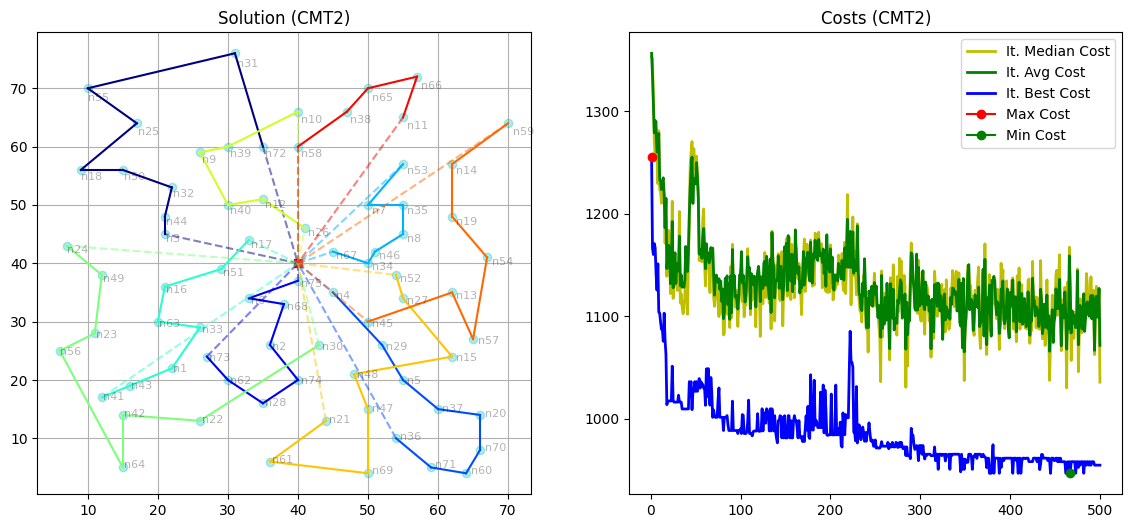

In [43]:
if optimal_cost:
    print(f'Optimal cost: {optimal_cost}')
    print(f'Best cost: {results["global_best_solution"]["cost"]}')
    print(
        f'Difference %: {round((results["global_best_solution"]["cost"] - optimal_cost) / optimal_cost * 100, 2)}')

if PLOT_SOLUTION:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_solution(results['global_best_solution'], matrix_coords, instance_name,
                                 results['best_solutions'], results['iterations_mean_costs'], results['iterations_median_costs'])


In [44]:
if PLOT_MOST_USED_ARCS:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.plot_most_used_arcs(
        results['iterations_best_solutions'], nodes, matrix_coords, instance_name)

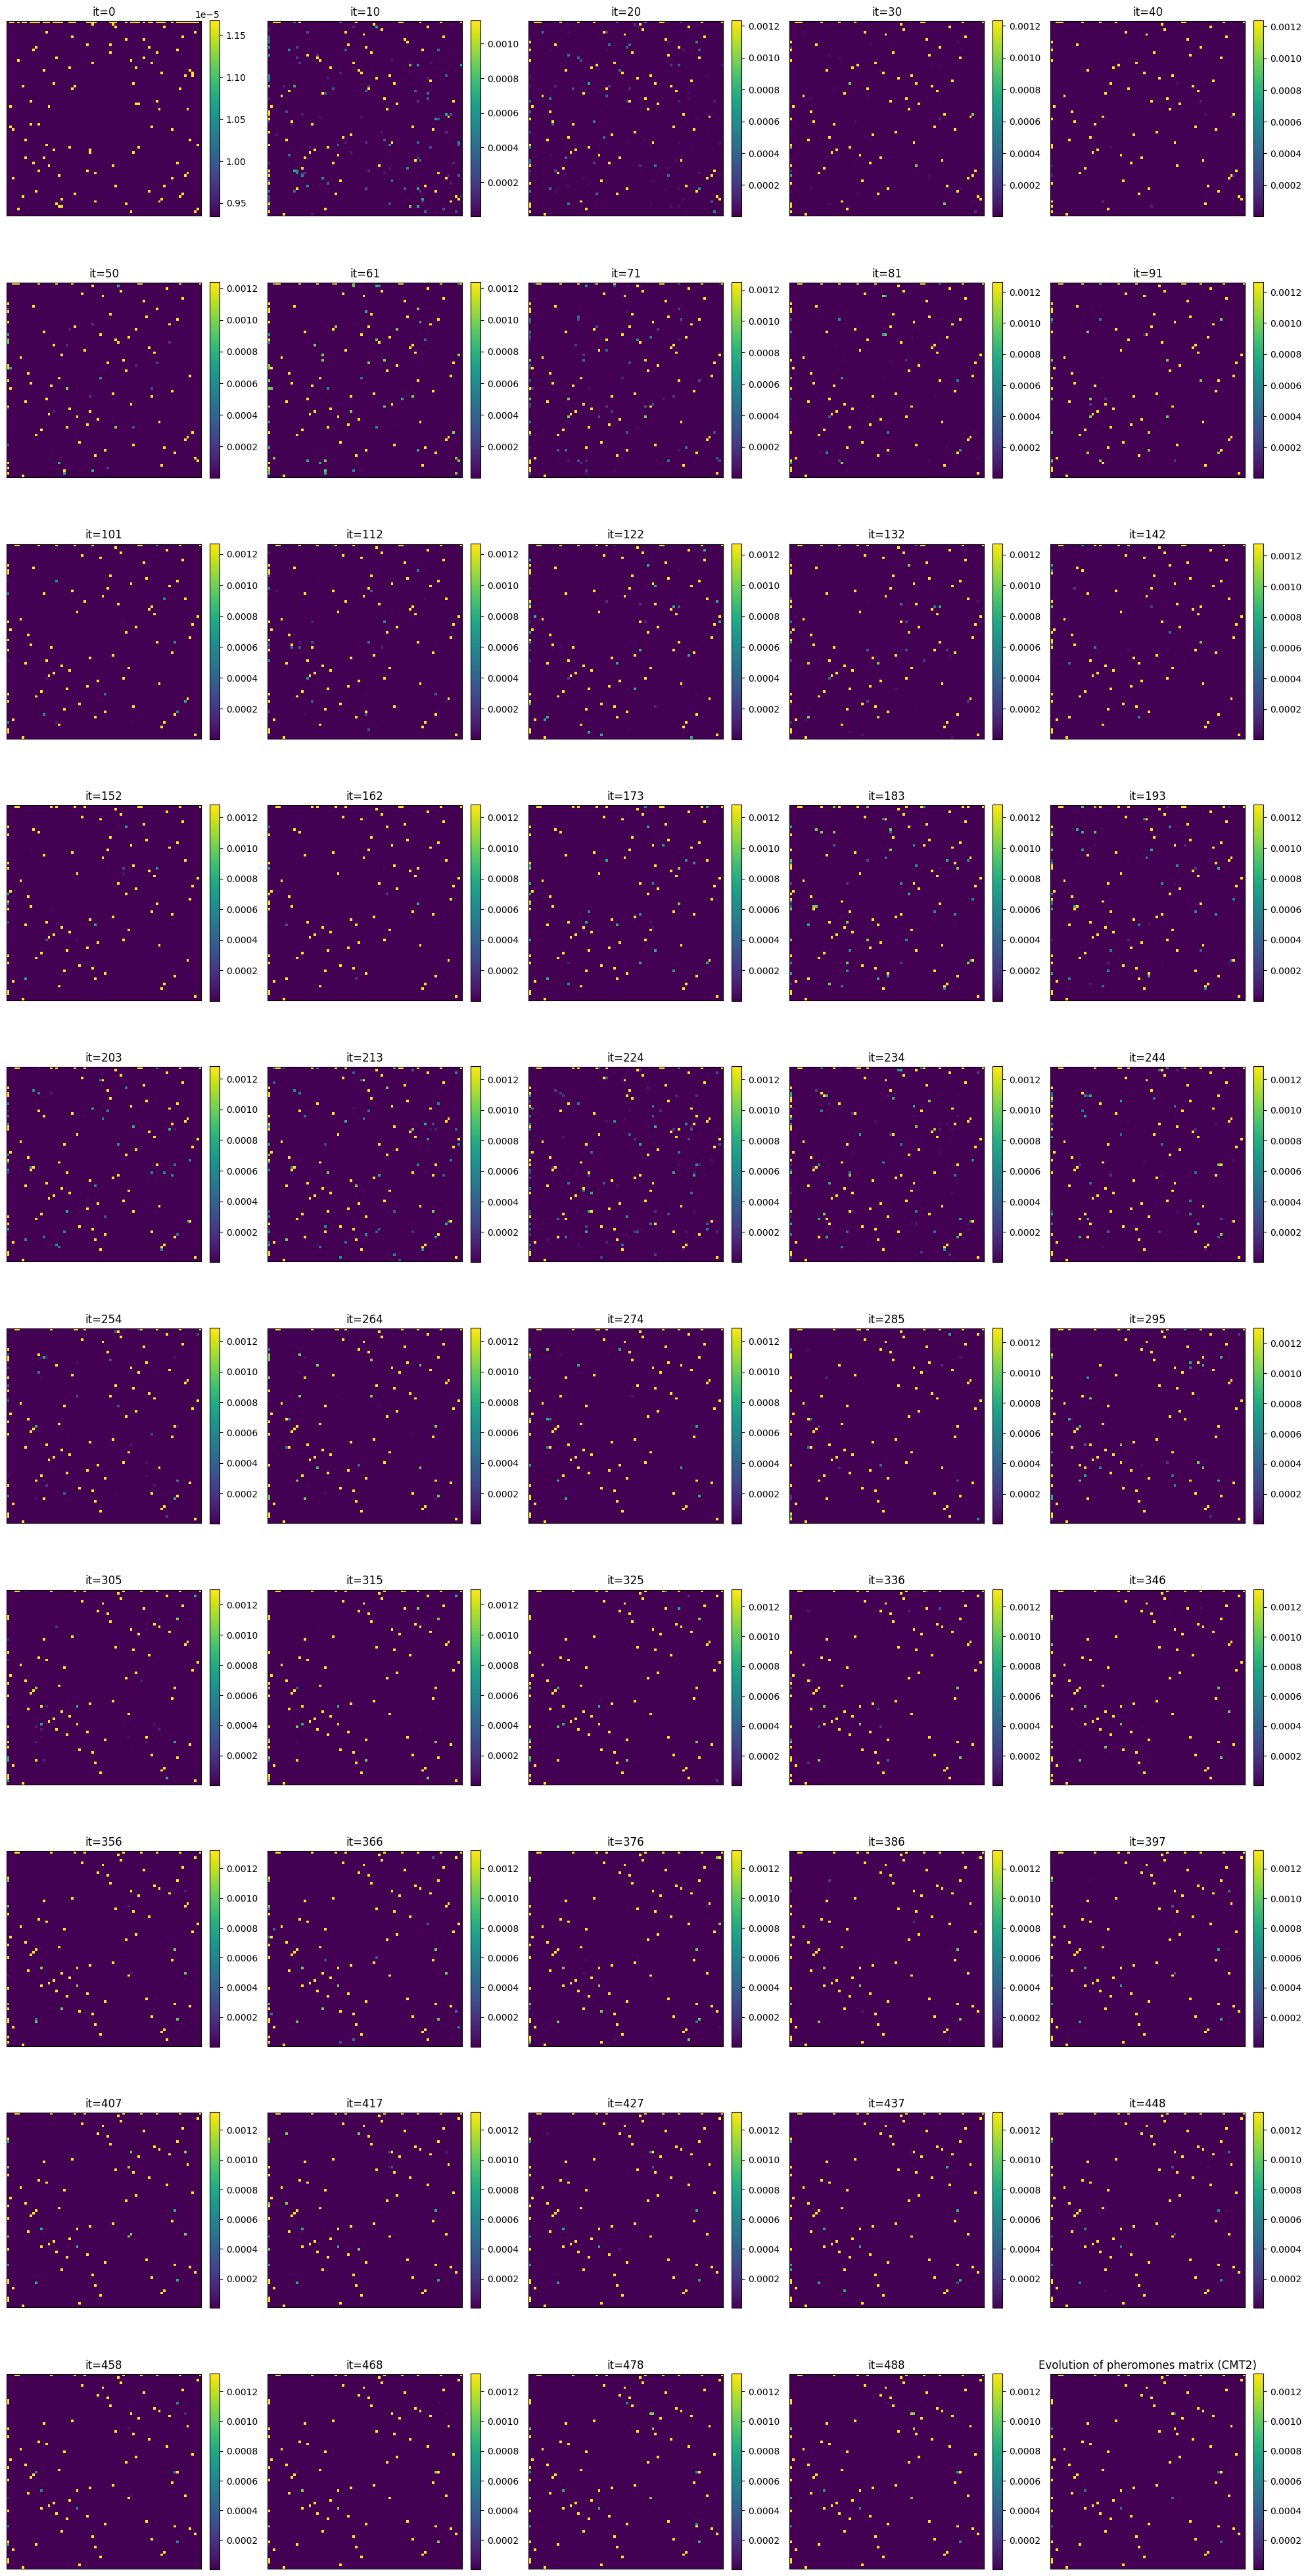

In [45]:
if PLOT_PHEROMONES_MATRIX:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.plot_pheromones_matrices(results['pheromones_matrices'], instance_name, max_plots=50)